# Zoomcamp Capstone Project - Price prediction for Berlin apartment rentals

## 1. Data Preperation and Sanitization

In [1]:
import ast
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor


%matplotlib inline

In [2]:
# Source - https://insideairbnb.com/berlin/
df = pd.read_csv("listings.csv")

In [3]:
with pd.option_context("display.max_columns", None):
    display(df.head())

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3176,https://www.airbnb.com/rooms/3176,20250923202926,2025-09-24,city scrape,Fabulous Flat in great Location,This beautiful first floor apartment is situa...,The neighbourhood is famous for its variety of...,https://a0.muscache.com/pictures/hosting/Hosti...,3718,https://www.airbnb.com/users/show/3718,Britta,2008-10-19,"Coledale, Australia",We love to travel ourselves a lot and prefer t...,within a day,100%,83%,f,https://a0.muscache.com/im/users/3718/profile_...,https://a0.muscache.com/im/users/3718/profile_...,Prenzlauer Berg,1.0,1.0,"['email', 'phone']",t,t,"Berlin, Germany",Prenzlauer Berg Südwest,Pankow,52.53471,13.41810,Entire rental unit,Entire home/apt,2,1.0,1 bath,1.0,2.0,"[""Cooking basics"", ""Wine glasses"", ""Crib"", ""Ho...",€105.00,63,730,63.0,63.0,730.0,730.0,63.0,730.0,NaN,t,0,0,0,140,2025-09-24,150,2,0,0,0,252,26460.0,2009-06-20,2025-08-09,4.63,4.67,4.52,4.65,4.70,4.92,4.61,First name and Last name: Nicolas Krotz <br/> ...,f,1,1,0,0,0.76
1,9991,https://www.airbnb.com/rooms/9991,20250923202926,2025-09-24,city scrape,Geourgeous flat - outstanding views,4 bedroom with very large windows and outstand...,Prenzlauer Berg is an amazing neighbourhood wh...,https://a0.muscache.com/pictures/42799131/59c8...,33852,https://www.airbnb.com/users/show/33852,Philipp,2009-08-25,"Berlin, Germany",Born in Munich - lives in and loves Berlin. Wo...,a few days or more,20%,0%,f,https://a0.muscache.com/im/users/33852/profile...,https://a0.muscache.com/im/users/33852/profile...,Prenzlauer Berg,1.0,1.0,"['email', 'phone']",t,t,"Berlin, Germany",Prenzlauer Berg Südwest,Pankow,52.53269,13.41805,Entire rental unit,Entire home/apt,7,2.5,2.5 baths,4.0,4.0,"[""Cooking basics"", ""Crib"", ""Stove"", ""Elevator""...",€135.00,6,14,6.0,6.0,14.0,14.0,6.0,14.0,NaN,t,0,1,14,241,2025-09-24,7,0,0,16,0,0,0.0,2015-08-09,2020-01-04,5.00,5.00,5.00,5.00,5.00,4.86,4.86,03/Z/RA/003410-18,f,1,1,0,0,0.06
2,14325,https://www.airbnb.com/rooms/14325,20250923202926,2025-09-24,city scrape,Studio Apartment in Prenzlauer Berg,The apartment is located on the upper second f...,NaN,https://a0.muscache.com/pictures/508703/24988a...,55531,https://www.airbnb.com/users/show/55531,Chris + Oliver,2009-11-18,"Berlin, Germany","From Berlin, Germany. We love to travel!",within a day,80%,22%,f,https://a0.muscache.com/im/users/55531/profile...,https://a0.muscache.com/im/users/55531/profile...,Prenzlauer Berg,4.0,5.0,"['email', 'phone', 'work_email']",t,t,NaN,Prenzlauer Berg Nordwest,Pankow,52.54813,13.40366,Entire rental unit,Entire home/apt,1,1.0,1 bath,0.0,1.0,"[""Ethernet connection"", ""Di

In [4]:
# Converting Amenities to text and vectorizing results
def amenities_to_text(amenities):
    return " ".join(amenities) if amenities else ""


df["amenities"] = df["amenities"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)
df["amenities_text"] = df["amenities"].apply(amenities_to_text)


tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.8,
    max_features=500,
    lowercase=True,
    stop_words="english",
)

tfidf.fit_transform(df["amenities_text"])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1126159 stored elements and shape (14274, 500)>

In [5]:
# Type casting truth values to integer
columns_with_truth_values = [
    "host_is_superhost",
    "host_has_profile_pic",
    "host_identity_verified",
]
for column in columns_with_truth_values:
    df[column] = (df[column] == "t").astype(int)

In [6]:
# Adding a new column to understand whether a listing has a license to run or not
df["is_licensed"] = (df.license.isnull() == False).astype(int)

In [7]:
# Converting percentage numericals to numberical columns
percentage_columns = [
    "host_response_rate",
    "host_acceptance_rate",
]
for column in percentage_columns:
    df[column] = (
        df[column].astype(str).str.strip("%").replace("nan", pd.NA).astype("Int64")
    )

In [8]:
# Converting price to float
df["price"] = pd.to_numeric(
    df["price"].str.replace("€", "", regex=False), errors="coerce"
)

In [9]:
# Drop rows with missing target
df = df.loc[df["price"].notna()].copy()

In [10]:
categorical_columns = [
    "neighbourhood",
    "neighbourhood_cleansed",
    "neighbourhood_group_cleansed",
    "property_type",
    "room_type",
]
numerical_columns = [
    "host_response_rate",
    "host_acceptance_rate",
    "host_is_superhost",
    "host_has_profile_pic",
    "host_identity_verified",
    "latitude",
    "longitude",
    "accommodates",
    "bathrooms",
    "bedrooms",
    "beds",
    "minimum_nights",
    "maximum_nights",
    "is_licensed",
]
final_df = df[categorical_columns + numerical_columns + ["amenities_text", "price"]]

# Fill categorical NaNs
final_df.loc[:, categorical_columns] = final_df[categorical_columns].fillna("")

# Drop rows with missing numeric values
final_df = final_df.loc[~final_df[numerical_columns].isna().any(axis=1)].copy()

In [11]:
zero_categorical = final_df[categorical_columns].isna().sum().sum()  # should be 0
zero_numercial = final_df[numerical_columns].isna().sum().sum()  # should be 0
zero_price = final_df["price"].isna().sum()  # should be 0
zero_amenities_text = final_df["amenities_text"].isna().sum()  # should be 0
zero_categorical, zero_numercial, zero_price, zero_amenities_text

(np.int64(0), np.int64(0), np.int64(0), np.int64(0))

## 2. Setting up validation framework

In [12]:
df_full_train, df_test = train_test_split(final_df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
len(df_train), len(df_val), len(df_test)

(4656, 1552, 1552)

In [13]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [14]:
y_train = df_train.price.values
y_val = df_val.price.values
y_test = df_test.price.values
del df_train["price"]
del df_val["price"]
del df_test["price"]

In [15]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_columns),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_columns),
        ("amenities", tfidf, "amenities_text"),
    ]
)
X_train = preprocessor.fit_transform(df_train)
X_val = preprocessor.transform(df_val)
X_test = preprocessor.transform(df_test)

## 3. EDA

In [16]:
df_full_train[categorical_columns].nunique()

neighbourhood                    18
neighbourhood_cleansed          135
neighbourhood_group_cleansed     12
property_type                    59
room_type                         4
dtype: int64

In [17]:
df.price.describe()

count    9221.000000
mean      129.439106
std        95.004596
min         5.000000
25%        70.000000
50%       104.000000
75%       160.000000
max       999.000000
Name: price, dtype: float64

<Axes: xlabel='price', ylabel='Count'>

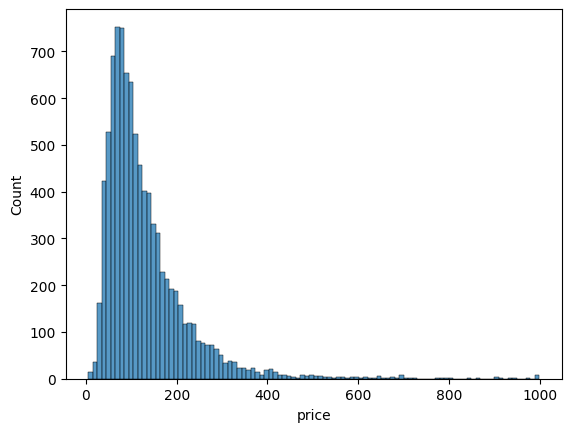

In [18]:
sns.histplot(df.price, bins=100)

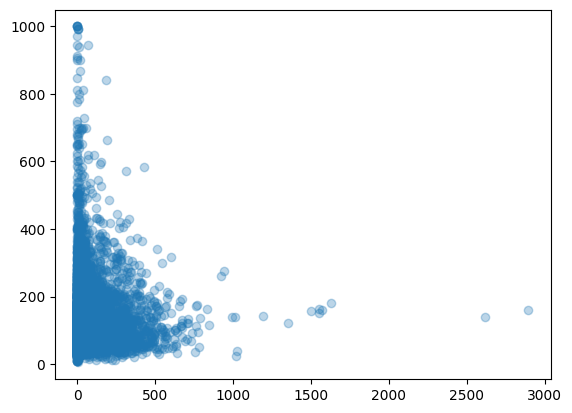

In [19]:
plt.scatter(df["number_of_reviews"], df["price"], alpha=0.3)
plt.show()

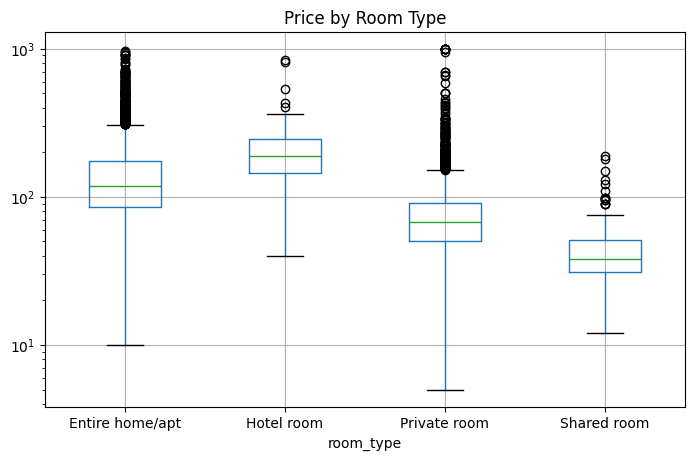

In [20]:
df.boxplot(column="price", by="room_type", figsize=(8, 5))
plt.yscale("log")
plt.title("Price by Room Type")
plt.suptitle("")
plt.show()

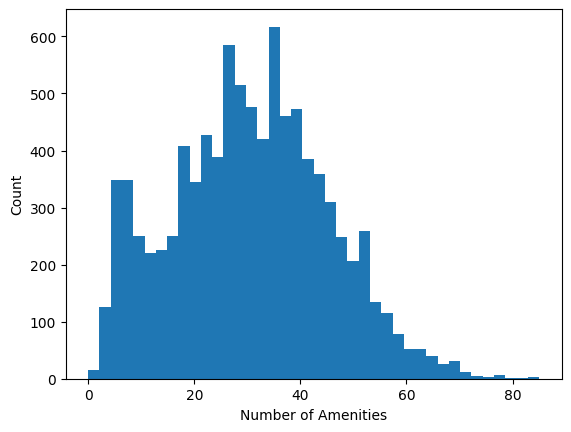

In [21]:
df["amenities_count"] = df["amenities"].apply(len)

plt.hist(df["amenities_count"], bins=40)
plt.xlabel("Number of Amenities")
plt.ylabel("Count")
plt.show()

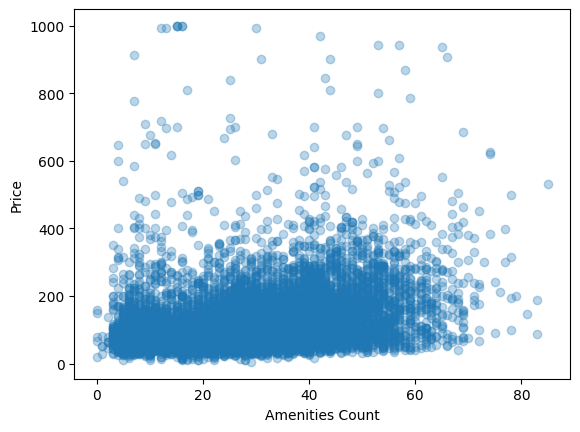

In [22]:
plt.scatter(df["amenities_count"], df["price"], alpha=0.3)
plt.xlabel("Amenities Count")
plt.ylabel("Price")
plt.show()

In [23]:
all_amenities = Counter(amenity for row in df["amenities"] for amenity in row)

pd.DataFrame(
    all_amenities.most_common(20),
    columns=["amenity", "count"],
)

,amenity,count
0,Wifi,8336
1,Kitchen,8245
2,Smoke alarm,7939
3,Hot water,7399
4,Hair dryer,7034
5,Hangers,6883
6,Dishes and silverware,6744
7,Bed linens,6687
8,Essentials,6546
9,Cooking basics,6491


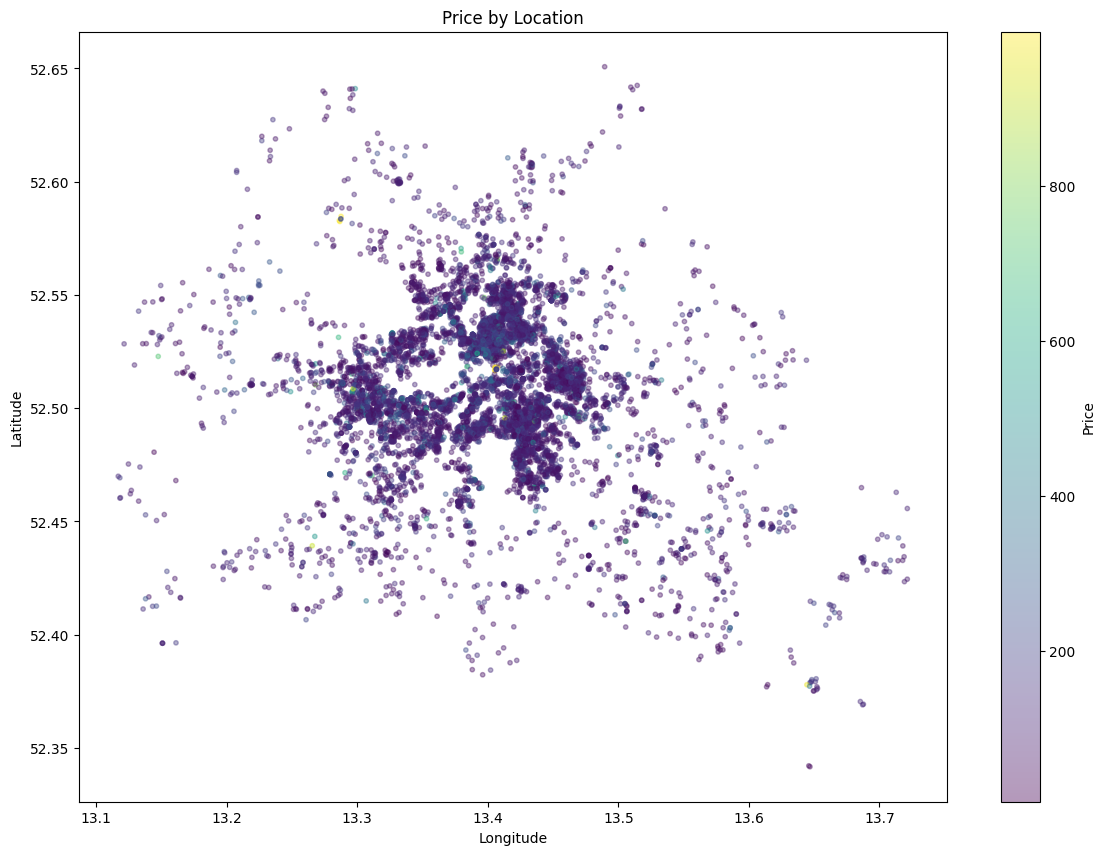

In [24]:
plt.figure(figsize=(14, 10))

plt.scatter(
    df["longitude"],
    df["latitude"],
    c=df["price"],
    s=10,
    alpha=0.4,
)

plt.colorbar(label="Price")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Price by Location")
plt.show()

## 5. Model Training & Parameter Tuning

### a. Decision Tree Regressor

In [25]:
scores = []

for depth in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeRegressor(
            max_depth=depth,
            min_samples_leaf=s,
        )
        dt.fit(X_train, y_train)
        rmse = root_mean_squared_error(y_val, dt.predict(X_val))
        scores.append((depth, s, rmse))

In [26]:
columns = ["max_depth", "min_samples_leaf", "rmse"]
df_scores = pd.DataFrame(scores, columns=columns)

In [27]:
df_scores_pivot = df_scores.pivot(
    index="min_samples_leaf", columns=["max_depth"], values=["rmse"]
)
df_scores_pivot.round(3)

rmse                                                  \
max_depth            NaN    1.0     2.0     3.0     4.0     5.0     6.0    
min_samples_leaf                                                           
1                 84.997  83.906  76.775  73.629  70.723  69.398  69.394   
5                 77.370  83.906  76.775  75.449  75.570  73.693  75.001   
10                75.874  83.906  76.775  75.449  74.526  75.165  74.337   
15                72.113  83.906  76.775  75.120  70.589  72.025  71.430   
20                69.938  83.906  76.775  75.120  70.594  69.986  69.392   
100               71.576  83.906  76.775  74.497  72.908  71.803  71.664   
200               73.135  83.906  76.775  75.070  74.156  73.526  73.253   
500               78.212  83.906  80.060  78.969  78.450  78.212  78.212   

                                          
max_depth           10.0    15.0    20.0  
min_samples_leaf                          
1                 74.706  73.214  86.226  
5                 74.373  75.102  76.301  
10                74.056  74.920  75.657  
15                71.801  71.800  72.265  
20                69.411  69.834  69.938  
100               71.576  71.576  71.576  
200               73.135  73.135  73.135  
500               78.212  78.212  78.212

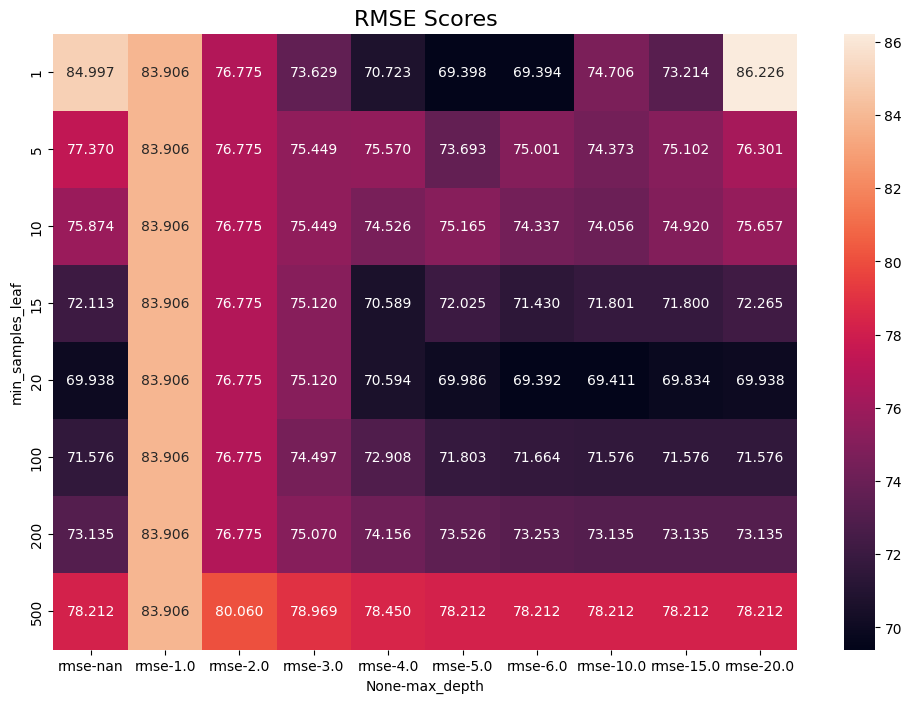

In [28]:
plt.figure(figsize=(12, 8))
sns.heatmap(
    df_scores_pivot,
    annot=True,
    fmt=".3f",
    annot_kws={"size": 10},
)
plt.title("RMSE Scores", fontsize=16)
plt.show()

In [29]:
dt_best = DecisionTreeRegressor(
    max_depth=6,
    min_samples_leaf=20,
)
dt_best.fit(X_train, y_train)

rmse_val = root_mean_squared_error(y_val, dt_best.predict(X_val))
print("Best validation RMSE:", rmse_val)

Best validation RMSE: 69.39195389338346


### b. Random Forest Regressor

In [30]:
dt = RandomForestRegressor(
    max_depth=6,
    min_samples_leaf=20,
    n_estimators=200,
    random_state=1,
)
dt.fit(X_train, y_train)
rmse_val = root_mean_squared_error(y_val, dt_best.predict(X_val))
print("Best validation RMSE:", rmse_val)

Best validation RMSE: 69.39195389338346


### c. XGBBoost

In [31]:
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
)

xgb.fit(X_train, y_train)
pred = xgb.predict(X_val)
rmse_log = root_mean_squared_error(y_val, pred)
print("Validation RMSE:", rmse)

Validation RMSE: 73.13487515770895


## Conclusion

DecisionTreeRegressor is the best model for our usecase.